# EVOLV MACHINE LEARNING CHALLENGE

### LEVEL 2
Through classical computer vision and non-Deep Learning techniques, use the images and their respective key points generated by the PoseNet to classify the yoga poses.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
os.sys.path
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

import math
from collections import Counter
from numpy import where
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Obtaining the dowloaded prototxt and weight files from the Posenet repository.

In [4]:
protoFile = "/content/gdrive/MyDrive/pose_deploy_linevec_faster_4_stages.prototxt.txt"
weightsFile = "/content/gdrive/MyDrive/pose_iter_160000.caffemodel"

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

Loading the training images from the Google Drive and locating the body parts using the obtained prototxt and weight files. The location of body parts is appended only if the confidence of the model exceeds a certain threshold which is 0.005 in this case.

In [ ]:
main_list = []
loc = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Train/{loc[k]}/*jpg")
    images.sort()

    for i in images:
      frame = cv2.imread(i)
      frame = cv2.resize(frame, (224, 224))
      
      inHeight, inWidth, channels = frame.shape
      inp = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                    (0, 0, 0), swapRB=False, crop=False)
      net.setInput(inp)

      out = net.forward()

      BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
      "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
      "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
      "Background": 15}

      points = []
      for i in range(len(BODY_PARTS)):
          heatMap = out[0, i, :, :]
      
          _, conf, _, point = cv2.minMaxLoc(heatMap)
          x = (inWidth * point[0]) / out.shape[3]
          y = (inHeight * point[1]) / out.shape[2]
      
          points.append((int(x), int(y)) if conf > 0.005 else None)

      main_list.append(points)

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Train/{loc[k]}/*png")
    images.sort()

    for i in images:
      frame = cv2.imread(i)
      frame = cv2.resize(frame, (224, 224))
      
      inHeight, inWidth, channels = frame.shape
      inp = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                    (0, 0, 0), swapRB=False, crop=False)
      net.setInput(inp)

      out = net.forward()

      BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
      "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
      "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
      "Background": 15}

      points = []
      for i in range(len(BODY_PARTS)):
          heatMap = out[0, i, :, :]
      
          _, conf, _, point = cv2.minMaxLoc(heatMap)
          x = (inWidth * point[0]) / out.shape[3]
          y = (inHeight * point[1]) / out.shape[2]
      
          points.append((int(x), int(y)) if conf > 0.005 else None)

      main_list.append(points)

Saving the obtained list of location of the body parts as a pickle file so that they can be used again without passing the images through the model again.

Loading the saved pickle file.

In [ ]:
f_name = "0point005.pkl"

open_file = open(f_name, "wb")
pickle.dump(main_list, open_file)
open_file.close()

In [5]:
open_file = open('/content/0point005.pkl', "rb")
main_list = pickle.load(open_file)
open_file.close()

The locations of the body parts of the first image are shown below.

In [6]:
main_list[0]

[(80, 160),
 (88, 120),
 (88, 120),
 (56, 152),
 (32, 176),
 (88, 120),
 (64, 152),
 (32, 184),
 (128, 80),
 (32, 176),
 (200, 184),
 (128, 80),
 (32, 176),
 (24, 184),
 (112, 104),
 (56, 120)]

Filling (0,0) as the co-ordinates for the points that were not located by the PoseNet model and converting the list to a form that can be used to train a machine learning model. 

In [7]:
main_list = [[v if v is not None else (0, 0) for v in nested] for nested in main_list]
main_list = np.array(main_list)
main_list = main_list.squeeze()
main_list = [[list(ele) for ele in i] for i in main_list]
main_list = [[item for sublist in sub_list for item in sublist] for sub_list in main_list]

In [8]:
cols = []
for i in range(32):
  cols.append(str(i))

main_list = np.array(main_list)
df = pd.DataFrame(main_list.reshape(len(main_list),32), columns=cols)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,80,160,88,120,88,120,56,152,32,176,88,120,64,152,32,184,128,80,32,176,200,184,128,80,32,176,24,184,112,104,56,120
1,56,128,88,120,88,120,64,160,56,184,88,120,64,168,32,192,96,216,64,168,192,184,88,216,64,168,40,184,96,144,48,80
2,0,0,0,0,72,112,0,0,0,0,80,120,0,0,0,0,0,0,0,0,80,128,0,0,0,0,80,120,0,0,48,64
3,56,128,64,96,56,88,80,136,56,168,120,88,96,152,16,144,160,16,168,88,184,144,160,16,184,88,200,152,128,56,32,72
4,88,176,96,152,96,152,88,176,72,192,104,144,80,176,72,192,120,88,136,136,152,176,120,88,136,136,152,176,104,120,152,72


Appending the target variable (True label) to the dataframe.

In [9]:
true_label = []
loc = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Train/{loc[k]}/*jpg")
    images.sort()
    for i in images:
      true_label.append(loc[k])

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Train/{loc[k]}/*png")
    images.sort()
    for i in images:
      true_label.append(loc[k])

df['Label'] = true_label
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,Label
0,80,160,88,120,88,120,56,152,32,176,88,120,64,152,32,184,128,80,32,176,200,184,128,80,32,176,24,184,112,104,56,120,downdog
1,56,128,88,120,88,120,64,160,56,184,88,120,64,168,32,192,96,216,64,168,192,184,88,216,64,168,40,184,96,144,48,80,downdog
2,0,0,0,0,72,112,0,0,0,0,80,120,0,0,0,0,0,0,0,0,80,128,0,0,0,0,80,120,0,0,48,64,downdog
3,56,128,64,96,56,88,80,136,56,168,120,88,96,152,16,144,160,16,168,88,184,144,160,16,184,88,200,152,128,56,32,72,downdog
4,88,176,96,152,96,152,88,176,72,192,104,144,80,176,72,192,120,88,136,136,152,176,120,88,136,136,152,176,104,120,152,72,downdog


In [10]:
X = df.drop(['Label'], axis=1)
y = df['Label']

Splitting the dataset in a way that 90% of the data (Training data) is used for training the model and the remaining 10% (Validation data) is used to measure the performance of the model.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

The dataset is trained on various machine learning algorithms achieving accuracy rates as shown.

In [12]:
classifiers = [['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
               ['XGB :', XGBClassifier()]]

predictions_df = pd.DataFrame(y_valid.values, columns=['actual_labels'])

for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train.values.ravel())
    predictions = classifier.predict(X_valid)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_valid, predictions))

DecisionTree : 0.8181818181818182
RandomForest : 0.8484848484848485
KNeighbours : 0.6767676767676768
SVM : 0.7878787878787878
GradientBoostingClassifier:  0.8787878787878788
XGB : 0.8282828282828283


In [13]:
preds = []
for name, i in classifiers:
  preds.append(i.predict(X_valid))

cm = []
for i in range(len(preds)):
  cm.append(confusion_matrix(y_valid, preds[i]))

In [14]:
plt.figure(figsize=(6, 5))
plt.suptitle("Confusion Matrices \n", fontsize=20)
plt.subplots_adjust(top=0.87, wspace = 0.6, hspace= 0.6)

titles = ['DecisionTree', 'RandomForest', 'KNeighbours ', 'SVM', 'GradientBoostingClassifier', 'XGB']

plt.legend(l1)
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.title(titles[i], fontsize=10)
    sns.heatmap(cm[i],annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 11})
plt.legend(l1)
plt.show()

NameError: ignored

<Figure size 432x360 with 0 Axes>

Then a Voting Classifier is built consisting of a Random Forest Classifier, an SVM Classifier and an XGB Classifier. A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.

In [15]:
clf1 = RandomForestClassifier()
clf2 = SVC(probability=True)
clf3 = XGBClassifier()
eclf1 = VotingClassifier(estimators=[('rf', clf1), ('svm', clf2), ('xgb', clf3)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_valid)
print(accuracy_score(y_valid, predictions))

0.8585858585858586


A Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True negatives and False Negatives are used to predict the metrics of a classification report.
The classification report for the predicitons made using the Voting Classifier is shown below.

In [16]:
report = classification_report(y_valid, predictions)
print(report)

              precision    recall  f1-score   support

     downdog       0.86      0.95      0.90        19
     goddess       0.88      0.50      0.64        14
       plank       0.92      0.89      0.91        27
        tree       0.69      1.00      0.82         9
    warrior2       0.87      0.90      0.89        30

    accuracy                           0.86        99
   macro avg       0.84      0.85      0.83        99
weighted avg       0.87      0.86      0.85        99



A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. 
Here, we can see the confusion matrix of the Voting Classifier trained on the dataset.

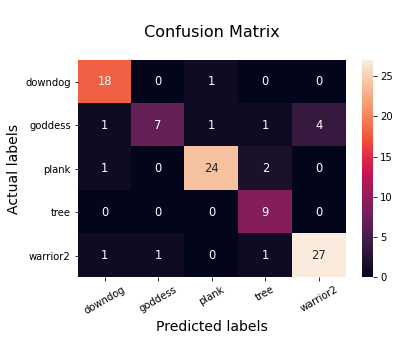

In [17]:
cm = confusion_matrix(y_valid, predictions)
l1 = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
l2 = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
ax = plt.axes()
sns.heatmap(cm, ax = ax, annot=True, annot_kws={"size": 11.5}, xticklabels=l1, yticklabels=l2, fmt='g')
ax.set_title('\n Confusion Matrix \n', fontsize = 16)
ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('Actual labels', fontsize = 14)
plt.xticks(rotation = 30)
plt.show()

## LEVEL-3
### Predicting the test dataset using the trained model

In [ ]:
main_list = []
loc = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Test/{loc[k]}/*jpg")
    images.sort()

    for i in images:
      frame = cv2.imread(i)
      frame = cv2.resize(frame, (224, 224))
      
      inHeight, inWidth, channels = frame.shape
      inp = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                    (0, 0, 0), swapRB=False, crop=False)
      net.setInput(inp)

      out = net.forward()

      BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
      "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
      "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
      "Background": 15}

      points = []
      for i in range(len(BODY_PARTS)):
          heatMap = out[0, i, :, :]

          _, conf, _, point = cv2.minMaxLoc(heatMap)
          x = (inWidth * point[0]) / out.shape[3]
          y = (inHeight * point[1]) / out.shape[2]
      
          points.append((int(x), int(y)) if conf > 0.005 else None)

      main_list.append(points)

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Test/{loc[k]}/*png")
    images.sort()

    for i in images:
      frame = cv2.imread(i)
      frame = cv2.resize(frame, (224, 224))
      
      inHeight, inWidth, channels = frame.shape
      inp = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                    (0, 0, 0), swapRB=False, crop=False)
      net.setInput(inp)

      out = net.forward()

      BODY_PARTS = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
      "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
      "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
      "Background": 15}

      points = []
      for i in range(len(BODY_PARTS)):
          heatMap = out[0, i, :, :]

          _, conf, _, point = cv2.minMaxLoc(heatMap)
          x = (inWidth * point[0]) / out.shape[3]
          y = (inHeight * point[1]) / out.shape[2]
      
          points.append((int(x), int(y)) if conf > 0.005 else None)

      main_list.append(points)

In [ ]:
f_name = "test_0point005.pkl"

open_file = open(f_name, "wb")
pickle.dump(main_list, open_file)
open_file.close()

In [18]:
open_file = open('/content/test_0point005.pkl', "rb")
test_list = pickle.load(open_file)
open_file.close()

In [19]:
test_list = [[v if v is not None else (0, 0) for v in nested] for nested in test_list]
test_list = np.array(test_list)
test_list = test_list.squeeze()
test_list = [[list(ele) for ele in i] for i in test_list]
test_list = [[item for sublist in sub_list for item in sublist] for sub_list in test_list]

In [20]:
cols = []
for i in range(32):
  cols.append(str(i))

test_list = np.array(test_list)
df_test = pd.DataFrame(test_list.reshape(len(test_list),32), columns=cols)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,96,144,112,136,104,128,144,56,144,56,112,136,112,136,200,192,112,120,144,48,104,144,112,120,144,40,192,184,112,96,200,104
1,128,144,136,128,136,128,160,168,184,200,136,128,160,160,176,184,88,48,88,48,16,176,80,56,48,120,16,176,104,96,40,64
2,136,184,128,144,128,136,152,168,176,192,128,136,152,168,176,192,88,56,64,120,40,176,88,56,64,120,40,176,104,104,40,48
3,40,144,72,120,72,120,56,160,32,184,72,128,48,152,24,200,112,56,128,16,64,168,120,40,128,16,184,176,96,80,120,200
4,40,160,48,128,40,136,32,160,24,176,48,128,32,160,24,184,88,72,104,120,120,168,88,72,112,128,128,176,64,104,144,128


In [21]:
test_true_label = []
loc = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Test/{loc[k]}/*jpg")
    images.sort()
    for i in images:
      test_true_label.append(loc[k])

for k in range(len(loc)):
    images = glob.glob(f"/content/gdrive/MyDrive/Test/{loc[k]}/*png")
    images.sort()
    for i in images:
      test_true_label.append(loc[k])

df_test['Label'] = test_true_label
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,Label
0,96,144,112,136,104,128,144,56,144,56,112,136,112,136,200,192,112,120,144,48,104,144,112,120,144,40,192,184,112,96,200,104,downdog
1,128,144,136,128,136,128,160,168,184,200,136,128,160,160,176,184,88,48,88,48,16,176,80,56,48,120,16,176,104,96,40,64,downdog
2,136,184,128,144,128,136,152,168,176,192,128,136,152,168,176,192,88,56,64,120,40,176,88,56,64,120,40,176,104,104,40,48,downdog
3,40,144,72,120,72,120,56,160,32,184,72,128,48,152,24,200,112,56,128,16,64,168,120,40,128,16,184,176,96,80,120,200,downdog
4,40,160,48,128,40,136,32,160,24,176,48,128,32,160,24,184,88,72,104,120,120,168,88,72,112,128,128,176,64,104,144,128,downdog


In [22]:
X_test = df_test.drop(['Label'], axis=1)
y_test = df_test['Label']

Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=32)
model = model.fit(X_train, y_train.values.ravel())

In [24]:
pred_rf = model.predict(X_test)

In [25]:
print(accuracy_score(y_test, pred_rf))

0.9126637554585153


In [26]:
report = classification_report(y_test, pred_rf)
print(report)

              precision    recall  f1-score   support

     downdog       0.95      0.95      0.95        94
     goddess       0.91      0.77      0.83        77
       plank       0.97      0.94      0.95       110
        tree       0.93      0.94      0.93        68
    warrior2       0.83      0.94      0.88       109

    accuracy                           0.91       458
   macro avg       0.92      0.91      0.91       458
weighted avg       0.92      0.91      0.91       458



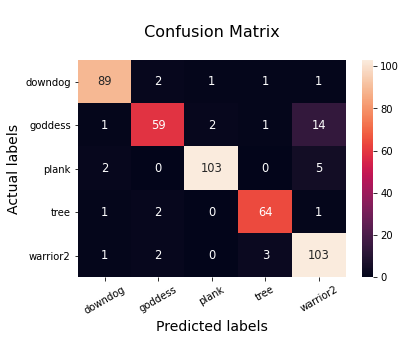

In [27]:
cm = confusion_matrix(y_test, pred_rf)
l1 = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
l2 = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
ax = plt.axes()
sns.heatmap(cm, ax = ax, annot=True, annot_kws={"size": 11.5}, xticklabels=l1, yticklabels=l2, fmt='g')
ax.set_title('\n Confusion Matrix \n', fontsize = 16)
ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('Actual labels', fontsize = 14)
plt.xticks(rotation = 30)
plt.show()

Support Vector Machine

In [28]:
from sklearn.svm import SVC
model_svm = SVC(random_state=32)
model_svm = model_svm.fit(X_train, y_train.values.ravel())

In [29]:
pred_svm = model_svm.predict(X_test)

In [30]:
print(accuracy_score(y_test, pred_svm))

0.8580786026200873


In [31]:
report = classification_report(y_test, pred_svm)
print(report)

              precision    recall  f1-score   support

     downdog       0.86      0.95      0.90        94
     goddess       0.92      0.58      0.71        77
       plank       0.94      0.94      0.94       110
        tree       0.88      0.87      0.87        68
    warrior2       0.75      0.89      0.81       109

    accuracy                           0.86       458
   macro avg       0.87      0.85      0.85       458
weighted avg       0.87      0.86      0.85       458



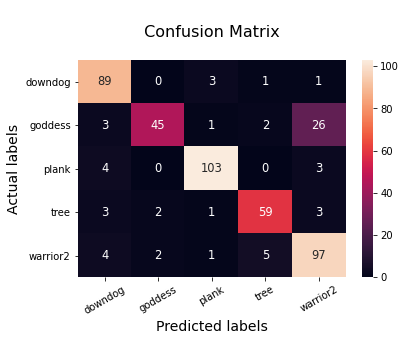

In [32]:
cm = confusion_matrix(y_test, pred_svm)
l1 = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
l2 = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
ax = plt.axes()
sns.heatmap(cm, ax = ax, annot=True, annot_kws={"size": 11.5}, xticklabels=l1, yticklabels=l2, fmt='g')
ax.set_title('\n Confusion Matrix \n', fontsize = 16)
ax.set_xlabel('Predicted labels', fontsize = 14)
ax.set_ylabel('Actual labels', fontsize = 14)
plt.xticks(rotation = 30)
plt.show()

## Analysis

* An accuracy of 91.2 % was achieved using a Random Forest Classifier while 85.8 % was achieved using an SVM classifier.
* As a general rule of thumb, Random Forest is believed to be better suited to multi-class problems than SVM. <br>
* In this specific case, it can be observed from the confusion matrices that both the models are recognizing slightly different patterns leading to the different accuracies in the prediction of different classes. <br>
* In the **Random Forest confusion matrix**, the majority of the inaccuracies made were classifying the pose 'Goddess' as 'Warrior2'.
* In the **SVM confusion matrix**, the same observation can be made but SVM is failing to classify a larger number of 'Goddess' images correctly than the Random Forest classifier.
* Random Forests are a combination of multiple decision trees which together act as an ensemble. It combines the outputs of the nodes of various trees to predict the final class.
* SVMs are best used to create a decision boundary that separates two classes. But in this case, there are 5 categories and the position of ankles in 'Goddess' and 'Warrior2' categories is similar. This may allow the SVM to treat the 'Goddess' pose as an outlier to the 'Warrior2' category. 
* Even though we are using a Radial Basis Function kernel instead of a Linear kernel, it fails to match the performance of the Random Forest classifier while classifying the 'Goddess' and 'Warrior2' categories. 